In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from ase.build import bulk

# Build a bulk structure of MgO with rocksalt crystal structure
# Then, replace some of the Mg atoms with Fe atoms at a specified ratio.
Mg_conv_cell = bulk("MgO", crystalstructure="rocksalt", a=4.2, cubic=True)
rng = np.random.default_rng(123)
replace_element = "Mg"
new_elements=("Mg", "Fe")
T_low = 100
T_high = 1000
ratio = 0.5

In [ ]:
from monty.serialization import loadfn
import tc.dataset
import tc.testing
from mace.calculators import mace_mp

# Only create the ensembles if they do not already exist
try:
    ensemble, endpoint_energies = loadfn(f"{''.join(new_elements)}O_ensemble4_default.json.gz")
    print("Ensemble already exist, skipping creation.")
except FileNotFoundError:
    print("Creating new ensembles...")
    calc = mace_mp(model="large", device="cuda", default_dtype="float32")
    ensemble, endpoint_energies = tc.dataset.make_ce_ensemble_from_mace(conv_cell=Mg_conv_cell, rng=rng, calc=calc, supercell_size=6,
                                                       replace_element=replace_element, new_elements=new_elements, bin_counts=50, bins=20)
    # This is likely to run out of VRAM, which is why we save the ensembles when we create them.
    stats = tc.testing.evaluate_ensemble_vs_mace(ensemble=ensemble, calc=calc, conv_cell=Mg_conv_cell, rng=rng, endpoint_energies=endpoint_energies,
                                                    replace_element=replace_element, new_elements=new_elements)


/home/colin/miniforge/envs/tc312/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


Ensemble already exist, skipping creation.


In [ ]:
calc = mace_mp(model="large", device="cuda", default_dtype="float64")
stats = tc.testing.evaluate_ensemble_vs_mace(ensemble=ensemble, calc=calc, conv_cell=Mg_conv_cell, rng=rng, endpoint_energies=endpoint_energies,
                                                     replace_element=replace_element, new_elements=new_elements, comps=(0.1, 0.2, 0.5, 0.8, 0.9))

Using Materials Project MACE for MACECalculator with /home/colin/.cache/mace/MACE_MPtrj_20229model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/home/colin/miniforge/envs/tc312/lib/python3.12/site-packages/mace/calculators/mace.py:143: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']


CE vs MACE:   0%|          | 0/30 [00:00<?, ?it/s]

 x_Li = 0.20 → CE = -6767.30 meV   MACE = -6688.88 meV
 x_Li = 0.90 → CE =  1495.63 meV   MACE =  1513.99 meV
 x_Li = 0.80 → CE =   498.45 meV   MACE =   600.00 meV
 x_Li = 0.10 → CE = -3251.27 meV   MACE = -3240.50 meV
 x_Li = 0.50 → CE = -10298.90 meV   MACE = -10428.80 meV
 x_Li = 0.50 → CE = -10083.98 meV   MACE = -10202.32 meV
 x_Li = 0.10 → CE = -3374.02 meV   MACE = -3407.00 meV
 x_Li = 0.50 → CE = -9470.51 meV   MACE = -9601.02 meV
 x_Li = 0.20 → CE = -7167.95 meV   MACE = -7084.15 meV
 x_Li = 0.50 → CE = -9676.37 meV   MACE = -9680.94 meV
 x_Li = 0.20 → CE = -5908.27 meV   MACE = -6012.06 meV
 x_Li = 0.90 → CE =  2397.96 meV   MACE =  2129.73 meV
 x_Li = 0.10 → CE = -3209.87 meV   MACE = -3285.33 meV
 x_Li = 0.80 → CE =  1182.45 meV   MACE =  1293.42 meV
 x_Li = 0.50 → CE = -8953.75 meV   MACE = -9014.13 meV
 x_Li = 0.10 → CE = -3215.55 meV   MACE = -3321.99 meV
 x_Li = 0.50 → CE = -9784.92 meV   MACE = -9863.94 meV
 x_Li = 0.20 → CE = -6982.82 meV   MACE = -6920.70 meV
 x_Li 

  0%|          | 0/10000 [00:00<?, ?it/s]

ratio: 0.5 CE energies: mean = -9699.64 meV, std =   462.63 meV, min = -11602.78 meV, max = -7316.46 meV
Energy window : [-28.205, 8.805] eV (200 bins, 0.1851 eV each)


Sampling 1 chain(s) from a cell with 512 sites: 100%|██████████| 102400000/102400000 [2:34:01<00:00, 11079.87it/s] 


min(raw) = -22.46814731718806 eV
max(raw) = 4.36422310012545 eV
ΔE = 26.83237041731351 eV


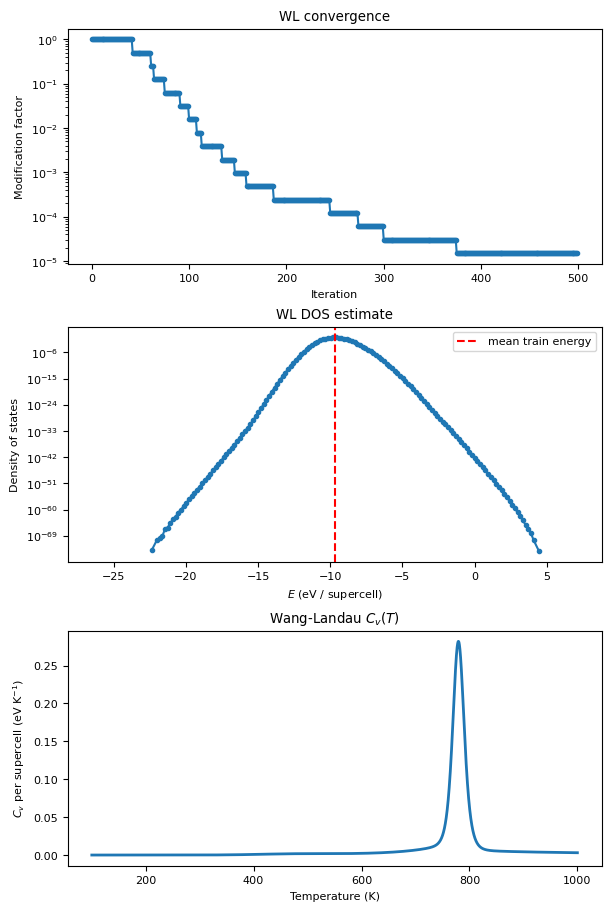

In [ ]:
"""
Single threaded Wang-Landau sampling
"""

import tc.wang_landau
import tc.testing

samples = tc.testing.sample_configs_fast(ensemble, rng, n_samples=10_000, ratio=ratio)
sampler, mu, min_E, max_E, bin_size = tc.wang_landau.run_wang_landau(ensemble=ensemble, samples=samples, rng=rng, 
                                                                     ratio=ratio, n_samples_per_site=200_000, num_bins=200,
                                                                     window_width_factor=(50,50), progress=True)
temperatures_K = np.linspace(T_low, T_high, 10_000)
Cv = tc.wang_landau.compute_thermodynamics(sampler, temperatures_K)
tc.wang_landau.generate_wl_plots( mu, min_E, max_E, bin_size, sampler, temperatures_K, Cv)

Metropolis:   0%|          | 0/200 [00:00<?, ?T/s]

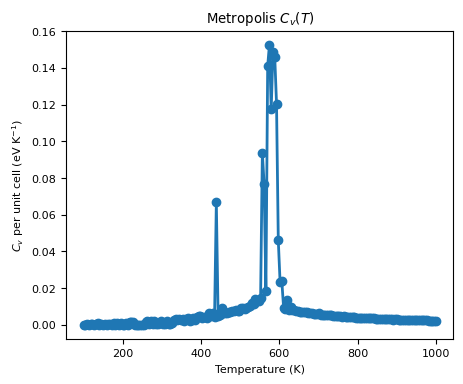

In [ ]:
"""
Parallel Metropolis heat-capacity sweep
"""

import os, numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import tc.metropolis

# Temperatures to sample and an independent RNG seed for every worker (avoids accidental correlations).
Ts = np.linspace(T_low, T_high, 200)
seed_root = np.random.SeedSequence(42) # master seed
child_seeds = seed_root.spawn(len(Ts))

def _single_Cv(T, seed):
    rng = np.random.default_rng(seed)
    return tc.metropolis.run_metropolis_heat_capacity(
        ensemble, # cheap shallow copy is enough (I hope)
        T,
        rng,
        replace_element=replace_element,
        new_elements=new_elements,
        ratio=ratio,
        n_steps_per_site=10_000,
        thin_target=40_000,
    )

# Fan the temperature points out to all available cores.
n_workers = os.cpu_count() // 2 # type: ignore # leave some cores free for the GUI and other tasks for my laptop
print(f"Using {n_workers} workers for parallel sampling.")
with ProcessPoolExecutor(max_workers=n_workers) as pool:
    Cv = list(tqdm(pool.map(_single_Cv, Ts, child_seeds), total=len(Ts), desc="Metropolis", unit="T"))

tc.metropolis.plot_cv_curve(Ts, np.array(Cv))


In [ ]:
"""
Parallel Wang–Landau over composition grid
------------------------------------------
* Computes Cv(T) for each `ratio` in `ratios`
* Uses all available CPU cores via ProcessPoolExecutor
* Stores results in Cv_mat  (shape: len(ratios) × len(T))
"""

import os, numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.auto import tqdm

import tc.wang_landau as wl
import tc.testing as tct

# ── input parameters ────────────────────────────────────────────────
ratios       = np.linspace(0.2, 0.8, 8)        # Mg fraction grid
temperatures = np.linspace(100, 1500, 10000)        # K
num_bins     = 200
window_width = (50, 50)
n_steps_per  = 200_000

# ── helper to run one composition slice ─────────────────────────────
def _cv_for_ratio(r):
    rng_local = np.random.default_rng(int(r * 1e6) ^ 12345)
    samples = tct.sample_configs_fast(ensemble, rng_local,
                                      n_samples=10_000, ratio=r)
    sampler, *_ = wl.run_wang_landau(
        ensemble=ensemble,
        samples=samples,
        rng=rng_local,
        ratio=r,
        n_samples_per_site=n_steps_per,
        num_bins=num_bins,
        window_width_factor=window_width,
        progress=False,  # disable progress bar in workers
    )
    Cv = wl.compute_thermodynamics(sampler, temperatures)
    return r, Cv

# ── launch workers ─────────────────────────────────────────────────
n_workers = 4
Cv_mat = np.empty((len(ratios), len(temperatures)))

with ProcessPoolExecutor(max_workers=n_workers) as pool:
    futures = {pool.submit(_cv_for_ratio, r): idx
               for idx, r in enumerate(ratios)}
    with tqdm(total=len(futures), desc="WL slices") as pbar:
        for fut in as_completed(futures):
            idx = futures[fut]
            ratio_ret, Cv_slice = fut.result()
            Cv_mat[idx, :] = Cv_slice
            pbar.update()



WL slices:   0%|          | 0/6 [00:00<?, ?it/s]

ratio: 0.95 CE energies: mean = -1561.36 meV, std =    76.52 meV, min = -1859.88 meV, max = -1318.58 meV
Energy window : [-5.387, 2.265] eV (200 bins, 0.0383 eV each)
ratio: 0.77 CE energies: mean = -7690.50 meV, std =   351.61 meV, min = -8883.97 meV, max = -6456.18 meV
Energy window : [-25.271, 9.890] eV (200 bins, 0.1758 eV each)
ratio: 0.22999999999999998 CE energies: mean =  -343.06 meV, std =   542.51 meV, min = -2580.35 meV, max =  1509.23 meV
Energy window : [-27.469, 26.783] eV (200 bins, 0.2713 eV each)
ratio: 0.05 CE energies: mean =  1434.14 meV, std =   292.91 meV, min =   107.27 meV, max =  2192.41 meV
Energy window : [-13.211, 16.080] eV (200 bins, 0.1465 eV each)
ratio: 0.41 CE energies: mean = -7257.89 meV, std =   425.46 meV, min = -9090.70 meV, max = -5603.73 meV
Energy window : [-28.531, 14.015] eV (200 bins, 0.2127 eV each)
ratio: 0.5900000000000001 CE energies: mean = -10632.76 meV, std =   496.44 meV, min = -12363.67 meV, max = -8757.55 meV
Energy window : [-35.4

In [ ]:
import tc.wang_landau
fig = tc.wang_landau.plot_cv_surface(ratios, temperatures, Cv_mat, mode="scatter", engine="plotly")
fig.show()